# modelling

### import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from functions.model_data import myModel
from functions.postproccessing import proccess_feature_importances, proccess_f1_vs_sample_size

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats
%store -r X_test_labeled_df
%store -r site_frequencies_df



### configurations
* save_plots -> True|False
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1

In [3]:
save_plots = True
scale = False

### counts of instances in all classes before oversampling

In [4]:
train_data_formodel['class'].value_counts()

4     105
15    100
16     61
0      53
11     45
13     36
14     36
2      36
10     30
7      30
6      30
5      27
8      27
1      24
12     21
3      18
9      17
Name: class, dtype: int64

### The class column is stored as the variable y and the variables identified as best by the 2 feature_selection notebook are used as features

In [5]:
y = np.array(train_data_formodel['class'])

if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(np.array(train_data_formodel[best_feats])))
else:
    X = np.array(np.array(train_data_formodel[best_feats]))

### the dimensions of the class and features are checked

In [6]:
print(X.shape)
print(y.shape)

(696, 15)
(696,)


### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores are calculated

In [7]:
my_model = myModel(X, y)

In [ ]:
my_model.evaluate_rfc()

making model:
1
running grid search on this training data fold
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
f1_df = pd.DataFrame(data = my_model.f1_dict)


In [ ]:
for key in my_model.f1_dict:
    print(len(my_model.f1_dict[key]))

### Below are the encodings for the class variable

In [ ]:
print(train_data_formodel['class'].unique())
print(list(uniques))

In [ ]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [ ]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

In [ ]:
f1_df_final.to_csv('output_datasets/cross_validation_results.csv')

In [ ]:
f1_df_final

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Archeological site", fontdict={'fontsize': 11})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('figures/site_specific_f1_scores.png')

In [ ]:
if save_plots:
    pd.DataFrame(data = f1_df_final.T.median()).to_csv('figures/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score

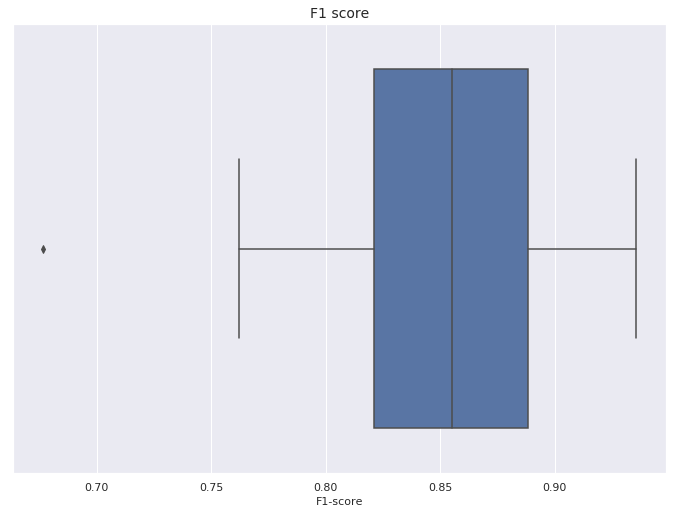

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(my_model.macro_f1_scores)
plot.set_title('F1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('figures/average-weighted f1_scores.png')

In [ ]:
with open('output_datasets/macro_f1_scores', 'a') as f:
    for score in my_model.macro_f1_scores:
        f.write(str(score))
        f.write('\n')

In [ ]:
if save_plots:
    pd.Series(pd.Series(my_model.macro_f1_scores).median()).to_csv('output_datasets//median_macro_f1.csv')

In [ ]:
pd.Series(my_model.macro_f1_scores).median()

### Boxplot showing accuracy scores

In [ ]:
sns.boxplot(my_model.accuracy_scores)

### Get feature importances

In [ ]:
if my_model.model_name == 'rfc':

    dataForPlot = proccess_feature_importances(my_data, my_model.feat_imp_dict, best_feats)


    sns.set_style("whitegrid")
    sns.set_style()
    sns.set(rc={'figure.figsize':(20,20)})
    plot = sns.boxplot(data = dataForPlot)
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
    plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
    plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
    plot.set_xlabel("Element", fontdict={'fontsize': 15})
    dataForPlot.to_csv('output_datasets/feat_importances.csv')

    if save_plots:
        fig = plot.get_figure()
        fig.savefig('figures/feature_importances.png')

In [ ]:
if my_model.model_name == 'rfc':
    dataForPlot.to_csv('output_datasets/feature_importances.csv')

In [ ]:
forPlot = proccess_f1_vs_sample_size(site_frequencies_df, f1_df_final)

In [ ]:
forPlot.to_csv('output_datasets/score_vs_sample_number.csv')

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
plot = sns.scatterplot(x ='Number of Observations', y = 'Mean F1 Score', data = forPlot, ci=False)
ax = plt.gca()
ax.set_title("Mean F1 score vs number of observations for each class")
fig = plot.get_figure()
if save_plots:
    fig.savefig('figures/f1scoresvsnumberobservations{0}.png'.format(my_model.model_name))